In [42]:
import re
import string
import pandas as pd

import nltk
from nltk.corpus import stopwords
# Download Spanish stopwords if not already downloaded
nltk.download('stopwords')

import spacy
import es_core_news_sm
nlp = es_core_news_sm.load()

from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from gensim.models import KeyedVectors

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
spanish_stopwords = set(stopwords.words('spanish'))

def remove_stopwords(text, stop_words= spanish_stopwords):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_words(words):
    doc = nlp(' '.join(words))
    return [token.lemma_ for token in doc]

def preprocess_text(text, remove_stopwords= False, remove_stopwords_func= remove_stopwords):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    # text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()

    if remove_stopwords:
        text = remove_stopwords_func(text)
        
    return text

def filter_tokens(tokens, stop_words= spanish_stopwords):
    return [tok for tok in tokens if ('_' in tok or tok not in stop_words)]


In [44]:
# Example usage
spanish_text = "¡Hola! Visitas https://example.com para más información. ¿Cuántos años tienes? Tengo 25 años."
cleaned_text = preprocess_text(spanish_text, remove_stopwords= False)
print(cleaned_text)

cleaned_text = remove_stopwords(cleaned_text)
print(cleaned_text)

cleaned_text = " ".join(lemmatize_words(cleaned_text.split()))
print(cleaned_text)

hola visitas para más información cuántos años tienes tengo años
hola visitas información cuántos años años
holar visita información cuántos año año


In [45]:
df = pd.read_csv('data/recetas_limpias.csv')
df.head()

,nombre,url,ingredientes,pasos,pais,duracion,porciones,calorias,categoria,contexto,comensales,tiempo,dificultad,categoria 2,valoracion,votos
0,berenjenas rellenas,https://www.elmueble.com/cocinas/comidas-salud...,"2 berenjenas, 1 pimiento rojo, 1 pimiento amar...",paso 1. lava bien las berenjenas y pártelas po...,españa,45 min,4,NaN,NaN,NaN,NaN,NaN,NaN,"alto en fibra, sin grasas trans, sin sodio o s...",NaN,NaN
1,alcachofas al horno con pico de gallo,https://www.elmueble.com/cocinas/comidas-salud...,"4 alcachofas, 1 limón, 400 g de carne picada (...","paso 1. precalentar el horno a 180?°c. , paso ...",españa,60 min,4,NaN,NaN,NaN,NaN,NaN,NaN,"bajo en calorías, sin grasa, alto en fibra",NaN,NaN
2,arroz basmati salteado con heura y verduras va...,https://www.elmueble.com/cocinas/comidas-salud...,"200 g de arroz basmati integral, 450 ml de agu...",paso 1. hervir el arroz basmati durante unos 2...,españa,40 min,4,NaN,NaN,NaN,NaN,NaN,NaN,"bajo en calorías, alto en grasas, bueno fuente...",NaN,NaN
3,tataki de atún,https://www.elmueble.com/cocinas/comidas-salud...,"200 gramos de atún rojo (fresco o congelado), ...",paso 1. cortar en forma rectangular para el ta...,españa,60 min,4,NaN,NaN,NaN,NaN,NaN,NaN,"bajo en calorías, sin grasa, alto en fibra",NaN,NaN
4,merluza al vapor a la gallega,https://www.elmueble.com/cocinas/comidas-salud...,"700 g de merluza en rodajas, 3 ajos, 1 manojo ...",paso 1. pelar y lavar las patatas. retirar el ...,españa,45 min,4,NaN,NaN,NaN,NaN,NaN,NaN,"bajo en calorías, sin grasa, alto en fibra",NaN,NaN


In [46]:
# Preprocess the 'pasos' column. Dont remove stopwords
train_data = df['pasos'].dropna().apply(preprocess_text).str.split()
train_data = pd.concat([train_data, df['contexto'].dropna().apply(preprocess_text).str.split()], axis=0) # add context sentences
train_data = pd.concat([train_data, df['ingredientes'].dropna().apply(preprocess_text).str.split()], axis=0) # add inhredient list

# Detect frequent bigrams and trigrams. Bigrams should appear in atleast 100 recipes
bigram = Phrases(train_data, min_count= 200, threshold= 20)
trigram = Phrases(bigram[train_data], min_count= 50, threshold= 10)

bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

# Step 4: Apply the phrasers to get merged n-grams
ngrammed_corpus = [trigram_phraser[bigram_phraser[doc]] for doc in train_data]

# remove stopwords from ngrammed corpus
final_corpus = [filter_tokens(doc) for doc in ngrammed_corpus]

# Train Word2Vec model
w2v_model = Word2Vec(sentences= final_corpus, vector_size= 300, window= 5, min_count= 20, workers=4)
# Save the model
w2v_model.save("models/w2v_ngram.model")

In [47]:
bigram_l = []; trigram_l = []
for word in w2v_model.wv.key_to_index:
    if '_' in word:
        if len(word.split('_')) == 2:
            bigram_l.append(word)
        elif len(word.split('_')) == 3:
            trigram_l.append(word)

bigram_l = list(set(bigram_l)); trigram_l = list(set(trigram_l));
#sort n-grams by frequency in descending order
bigram_l = sorted(bigram_l, key= lambda x: w2v_model.wv.get_vecattr(x, 'count'), reverse= True)
trigram_l = sorted(trigram_l, key= lambda x: w2v_model.wv.get_vecattr(x, 'count'), reverse= True)

In [48]:
# find word most similar to a sentence
def most_similar_sentence(model, sentence, topn=10):
    # Preprocess the sentence
    preprocessed_sentence = preprocess_text(sentence)
    # Tokenize the preprocessed sentence
    tokens = preprocessed_sentence.split()
    # Get the vector for the sentence by averaging the word vectors
    sentence_vector = sum(model.wv[word] for word in tokens if word in model.wv) / len(tokens)
    # Find the most similar words to the sentence vector
    similar_words = model.wv.similar_by_vector(sentence_vector, topn=topn)
    return similar_words

most_similar_sentence(w2v_model, "aceite de oliva", topn=10)

[('oliva', 0.79664546251297),
 ('aceite', 0.7866340279579163),
 ('girasol', 0.6707289814949036),
 ('ajos_picados', 0.634911298751831),
 ('buen_chorro', 0.6053799390792847),
 ('vinagre_balsámico', 0.58964604139328),
 ('de_oliva_virgen', 0.5894920825958252),
 ('ajo_molido', 0.5862055420875549),
 ('vinagre_blanco', 0.5793644785881042),
 ('pellizco', 0.5784677863121033)]

### Fine-Tune Spanish Billion Words (SBW) Word2Vec Model

In [49]:
# Load the binary Spanish Billion Words(SBW) Word2Vec model
sbw_w2v = KeyedVectors.load_word2vec_format("C:\AI Projects\Data\SBW-vectors-300-min5.bin\sbw_vectors.bin", binary=True)

# Convert KeyedVectors to full Word2Vec (hacky)
sbw_finetuned_w2v_ngram = Word2Vec(vector_size=300, min_count=1)

sbw_finetuned_w2v_ngram.build_vocab([list(sbw_w2v.key_to_index.keys())], update=False)
sbw_finetuned_w2v_ngram.wv.vectors = sbw_w2v.vectors
sbw_finetuned_w2v_ngram.wv.key_to_index = sbw_w2v.key_to_index
sbw_finetuned_w2v_ngram.wv.index_to_key = sbw_w2v.index_to_key

# # Update vocabulary and retrain
sbw_finetuned_w2v_ngram.build_vocab(final_corpus, update=True)
sbw_finetuned_w2v_ngram.train(final_corpus, total_examples=len(final_corpus), epochs=5)

sbw_finetuned_w2v_ngram.save("models/sbw_finetuned_w2v_ngram.model")

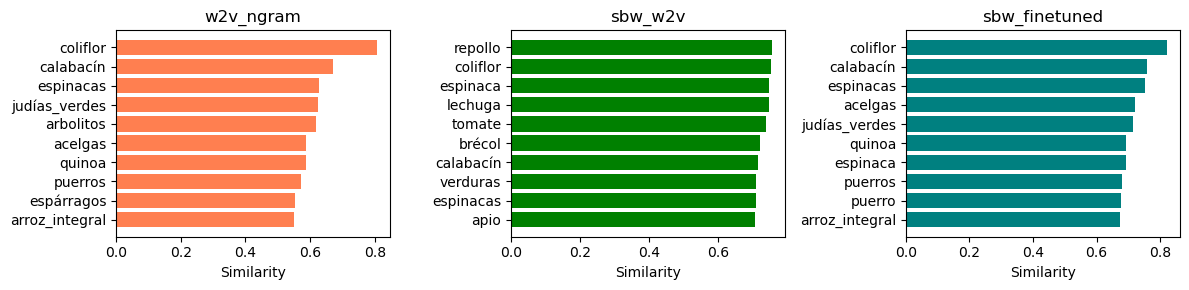

In [60]:
import matplotlib.pyplot as plt

def plot_topn_similar(word, topn=10):
    # Get most similar words for each model
    sim_w2v = w2v_model.wv.most_similar(word, topn=topn)
    sim_sbw = sbw_w2v.most_similar(word, topn=topn) if word in sbw_w2v else []
    sim_sbw_finetuned = sbw_finetuned_w2v_ngram.wv.most_similar(word, topn=topn) if word in sbw_finetuned_w2v_ngram.wv else []

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    titles = ['w2v_ngram', 'sbw_w2v', 'sbw_finetuned']

    for ax, sim, cc, title in zip(axes, [sim_w2v, sim_sbw, sim_sbw_finetuned], ['coral','green','teal'], titles):
        if sim:
            words, scores = zip(*sim)
            ax.barh(words, scores, color = cc)
            ax.invert_yaxis()
            ax.set_title(title)
            ax.set_xlabel('Similarity')
        else:
            ax.set_title(f"{title}\n(word not in vocab)")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_topn_similar('brócoli', topn=10)

### Manual Ingredient List for Logistic Regression

I am manually creating a list of ingredients to build a logistic regression model that predicts whether a word or n-gram in the vocabulary is an ingredient or not. This approach is a temporary solution and will be replaced in the future by more advanced techniques such as Named Entity Recognition (NER) and Part-of-Speech (POS) tagging, once I am more familiar with those methods.

In [51]:
# Example ingredient list (replace with your actual list)
ingrediente_list = ['aceite', 'sal', 'azúcar', 'harina', 'huevo', 'leche', 'tomate', 'cebolla', 'ajo', 'pollo', 'arroz', 'jamón',
                 'pasta', 'carne', 'pimiento', 'pimienta', 'zanahoria', 'papa', 'queso', 'mantequilla', 'chocolate', 'fruta', 'verdura',
                 'pescado', 'marisco', 'especias', 'hierbas', 'vinagre', 'salsa', 'mostaza', 'mayonesa', 'ketchup', 'vainilla',
                 'pan', 'tortilla', 'yogur', 'gelatina', 'miel', 'azafrán', 'pimienta', 'comino', 'orégano', 'laurel', 'maíz', 
                 'canela', 'clavo', 'jengibre', 'nuez', 'agua', 'crema', 'masa', 'limón','oliva', 'cerdo', 'atún', 'jugo', 'naranja',
                 'patata', 'champiñon', 'vino', 'calabaza', 'coco', 'avena', 'garbanzo', 'espinaca', 'sofrito', 'piña', 'cilantro',
                 'pimentón', 'brócoli', 'almendra', 'fresa', 'coliflor', 'yema', 'chorizo', 'mermelada', 'berenjena', 'trigo', 'vegetal',
                 'verdadur', 'bacon', 'mango', "quinoa", "fideo", "aceituna", "limon", 'pepino', 'chile', 'camaron', 'cacao', 'lenteja',
                 'margarina', 'frijol', 'pavo', 'yuca', 'tofu', 'romero', 'perejil', 'brandy', 'alcachofa', 'camarón', 'ostión', 'soja',
                 'soya', 'turrón', 'fécula', 'cúrcuma', 'sésamo', 'chía', 'chia', 'mozzarella', 'culantro', 'hierbabuena', 'manzana',
                 'espirulina', 'cardamomo', 'semilla', 'hoja', 'melón', 'kiwi', 'papaya', 'freson', 'mora', 'salmón', 'pita', 'cruton']

# Create DataFrame with word and is_ingrediente columns
df_vocab = pd.DataFrame(index= list(w2v_model.wv.key_to_index.keys()), columns= ['is_ingrediente'])
for i_idx in df_vocab.index:
    df_vocab.loc[i_idx, 'is_ingrediente'] = any([ww in i_idx for ww in ingrediente_list])

# save data
df_vocab.dropna().to_csv('data/is_ingrediente.csv')
df_vocab.head()

,is_ingrediente
sal,True
aceite,True
gramos,False
si,False
bien,False


In [52]:
df_vocab['is_ingrediente'].sum()/df_vocab.shape[0]

0.07504263786242182